# ***Tarea 1. Effective Spread***

### Luis Eduardo Jiménez del Muro - 28/08/2025

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.alpha'] = 0.3

## Block method

In [2]:
data = pd.read_csv('data/aapl_5m_train.csv')
data.drop(columns=['Unnamed: 0', 'Gmtoffset', 'Datetime', 'Volume'], inplace=True)
data['Diff'] = data['Close'].diff()
data = data.dropna().reset_index(drop=True)

windows = [5, 10, 20, 50, 100]


for window in windows:
    covs = [None] * len(data)

    for i in range(len(data) - 2*window + 1):
        up_block = data['Diff'][i:i+window]
        down_block = data['Diff'][i+window:i+2*window]

        cov = np.cov(up_block, down_block)[0][1]
        covs[i + 2*window - 1] = cov
        

    data[f'Cov_{window}'] = covs
    data[f'Spread_{window}'] = 2 * np.sqrt(np.abs(data[f'Cov_{window}']))


bid_ask = pd.DataFrame()
for i in range(len(windows)):
    bid_ask[f'Bid_{windows[i]}'] = np.where(data['Diff'] > 0, #Si subió entonces es un ask
                                            data['Close'] - data[f'Spread_{windows[i]}'], #Restar spread convierte a bid
                                            data['Close']) #Ask
    bid_ask[f'Ask_{windows[i]}'] = np.where(data['Diff'] > 0,
                                            data['Close'], #Bid
                                            data['Close'] + data[f'Spread_{windows[i]}']) #Sumar spread convierte a ask
bid_ask

,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,131.8900,NaN,131.8900,NaN,131.8900,NaN,131.8900,NaN,131.8900,NaN
1,NaN,132.0600,NaN,132.0600,NaN,132.0600,NaN,132.0600,NaN,132.0600
2,NaN,132.2500,NaN,132.2500,NaN,132.2500,NaN,132.2500,NaN,132.2500
3,131.5900,NaN,131.5900,NaN,131.5900,NaN,131.5900,NaN,131.5900,NaN
4,131.4489,NaN,131.4489,NaN,131.4489,NaN,131.4489,NaN,131.4489,NaN
...,...,...,...,...,...,...,...,...,...,...
39567,128.9110,129.0550,128.9907,129.0550,128.9689,129.0550,129.0082,129.0550,128.8545,129.0550
39568,129.1743,129.3800,129.3518,129.3800,129.3090,129.3800,129.3328,129.3800,129.1800,129.3800
39569,129.5881,129.7644,129.5720,129.7644,129.6559,129.7644,129.7279,129.7644,129.5620,129.7644
39570,129.7738,129.9500,129.7679,129.9500,129.8715,129.9500,129.8953,129.9500,129.7465,129.9500


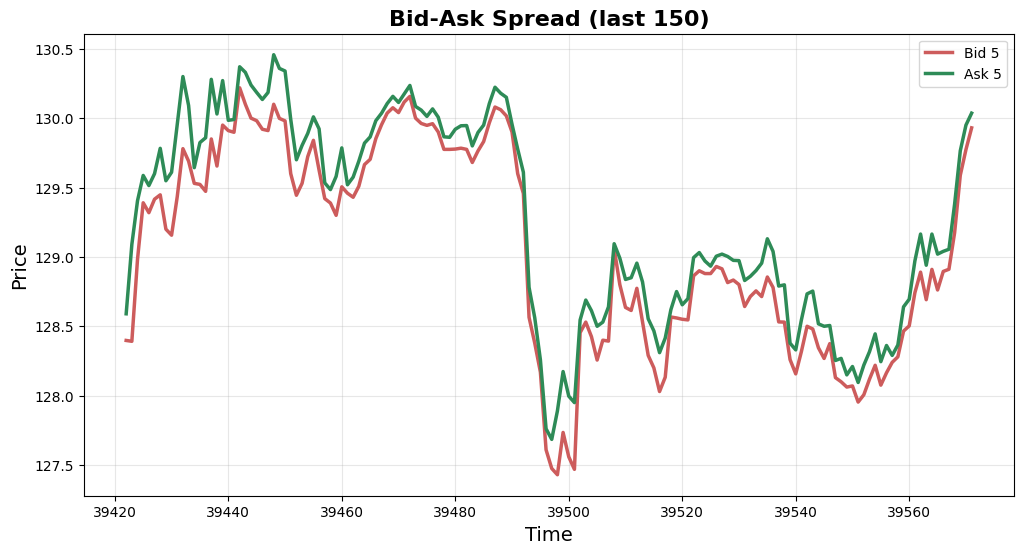

In [3]:
plt.figure()
plt.plot(bid_ask['Bid_5'].tail(150), label='Bid 5', color='indianred', lw=2.5)
plt.plot(bid_ask['Ask_5'].tail(150), label='Ask 5', color='seagreen', lw=2.5)
plt.title('Bid-Ask Spread (last 150)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

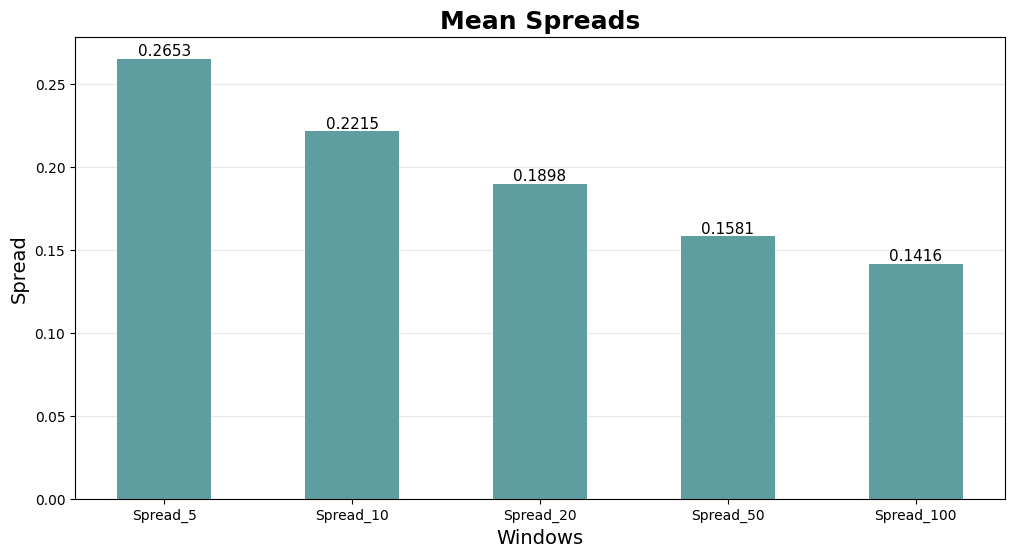

In [4]:
mean_spreads = [data[f'Spread_{window}'].mean() for window in windows]
plt.figure(figsize=(12, 6))
plt.bar([f'Spread_{window}' for window in windows], mean_spreads, color='cadetblue', zorder=2, width=0.5)

for i, v in enumerate(mean_spreads):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=11)

plt.title('Mean Spreads', fontsize=18)
plt.ylabel('Spread', fontsize=14)
plt.xlabel('Windows', fontsize=14)
plt.grid(alpha=0.3, zorder=0, axis='y')
plt.show()

## Serial covariance method

In [5]:
data = pd.read_csv('data/aapl_5m_train.csv')
data.drop(columns=['Unnamed: 0', 'Gmtoffset', 'Datetime', 'Volume'], inplace=True)
data['Diff'] = data['Close'].diff()
data['Diff_Shift'] = data['Diff'].shift()
data = data.dropna().reset_index(drop=True)

windows = [5, 10, 20, 50, 100]


for window in windows:
    data[f'W_{window}'] = data['Diff'].rolling(window=window).cov(data['Diff_Shift'])

for i in range(len(windows)):
    data[f'Spread_{windows[i]}'] = 2 * np.sqrt(np.abs(data[f'W_{windows[i]}']))


bid_ask = pd.DataFrame()
for i in range(len(windows)):
    bid_ask[f'Bid_{windows[i]}'] = np.where(data['Diff'] > 0, #Si subió entonces es un ask
                                            data['Close'] - data[f'Spread_{windows[i]}'], #Restar spread convierte a bid
                                            data['Close']) #Ask
    bid_ask[f'Ask_{windows[i]}'] = np.where(data['Diff'] > 0,
                                            data['Close'], #Bid
                                            data['Close'] + data[f'Spread_{windows[i]}']) #Sumar spread convierte a ask
bid_ask

,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,NaN,132.0600,NaN,132.0600,NaN,132.0600,NaN,132.0600,NaN,132.0600
1,NaN,132.2500,NaN,132.2500,NaN,132.2500,NaN,132.2500,NaN,132.2500
2,131.5900,NaN,131.5900,NaN,131.5900,NaN,131.5900,NaN,131.5900,NaN
3,131.4489,NaN,131.4489,NaN,131.4489,NaN,131.4489,NaN,131.4489,NaN
4,131.1200,131.6853,131.1200,NaN,131.1200,NaN,131.1200,NaN,131.1200,NaN
...,...,...,...,...,...,...,...,...,...,...
39564,128.9622,129.0550,128.8843,129.0550,128.9651,129.0550,128.9751,129.0550,128.9221,129.0550
39565,129.2708,129.3800,129.1955,129.3800,129.2592,129.3800,129.2918,129.3800,129.2466,129.3800
39566,129.5324,129.7644,129.6902,129.7644,129.7121,129.7644,129.7122,129.7644,129.6123,129.7644
39567,129.7385,129.9500,129.8063,129.9500,129.8584,129.9500,129.8608,129.9500,129.7886,129.9500


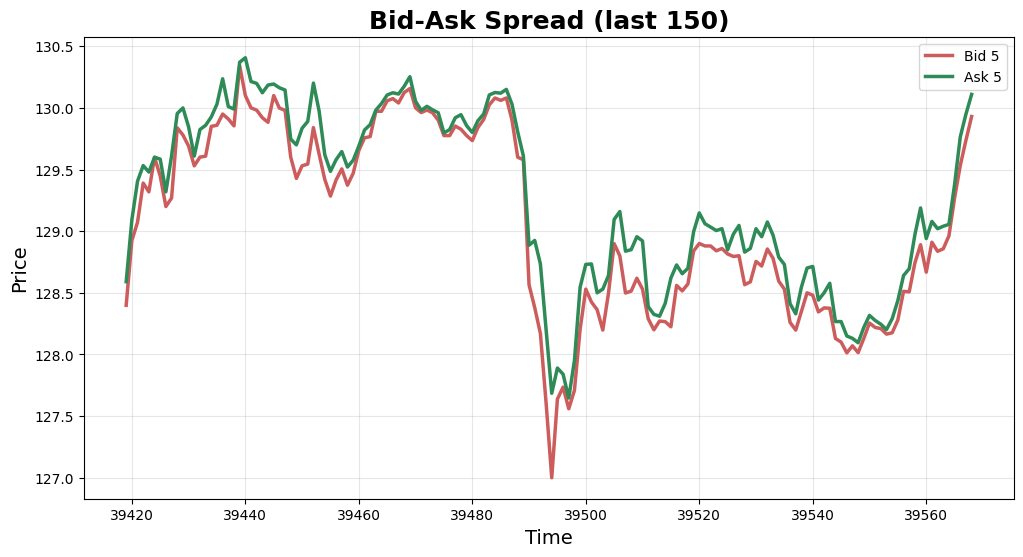

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(bid_ask['Bid_5'].tail(150), label='Bid 5', color='indianred', lw=2.5)
plt.plot(bid_ask['Ask_5'].tail(150), label='Ask 5', color='seagreen', lw=2.5)
plt.title('Bid-Ask Spread (last 150)', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

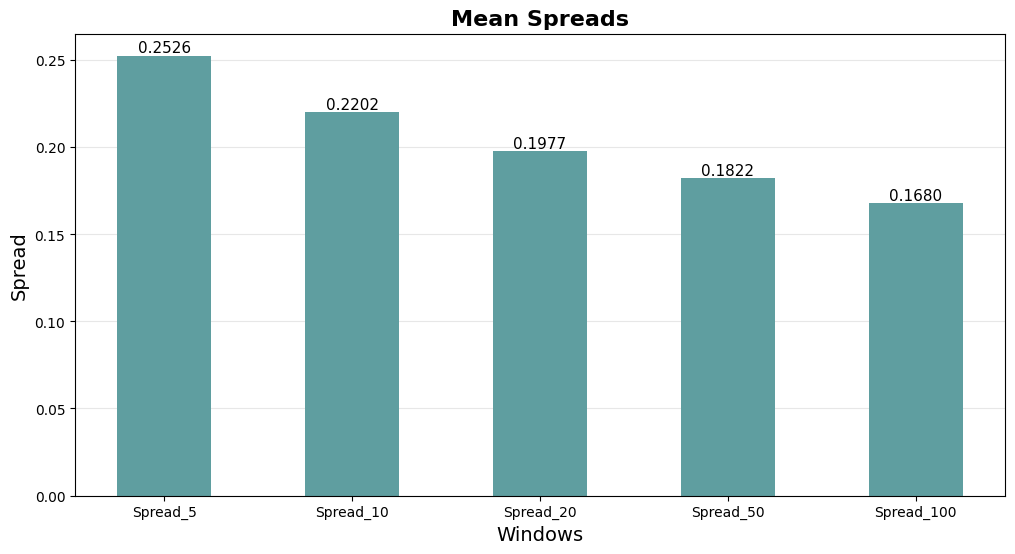

In [7]:
mean_spreads = [data[f'Spread_{window}'].mean() for window in windows]
plt.figure(figsize=(12, 6))
plt.bar([f'Spread_{window}' for window in windows], mean_spreads, color='cadetblue', zorder=2, width=0.5)

for i, v in enumerate(mean_spreads):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=11)

plt.title('Mean Spreads')
plt.ylabel('Spread')
plt.xlabel('Windows')
plt.grid(zorder=0, axis='y')
plt.show()